**Nom du / des étudiant(s)** : ETUDIANT 1 - ETUDIANT 2

# Mise en correspondance d'images par points d'intérêt

Les TP de traitement d'images sont réalisés en Python3, à l'aide de la librairie [scikit-image](http://scikit-image.org/docs/stable/). Les tableaux utilisés  (`ndarray`) par cette librairie pour manipuler les images proviennent de la librairie [numpy](https://docs.scipy.org/doc/). L'affichage des images et autres figures est réalisé grace à [matplotlib](https://matplotlib.org/contents.html). La documentation de ces trois librairies vous sera donc bien utile.

Dans ce TP, les questions seront indiquées dans un bloc **question**, et les réponses seront à donner dans le bloc **réponse**  situé en dessous du bloc de question. Vos réponses sont à rédiger en [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Vous pourrez ainsi répondre non seulement avec du texte, mais aussi avec des tableaux et des images.

Ce TP est à réaliser en <u>une</u> séances d'1h30.

**Remarque importante:** Les questions posées dans ce TP requièrent généralement des <u>réponses courtes mais justifées</u>. Un simple oui ou non ne nous est d'aucune utilité pour juger de votre compréhension de la question et de sa réponse...

**Autre remarque:** Il y a parfois plusieurs sous-questions dans une même question. <u>Pensez a répondre à toutes les sous-questions</u>.

Ce TP est une version très modifiée d'une des démo de https://github.com/scikit-image/scikit-image-demos

In [6]:
%matplotlib inline
# la ligne précédente permet d'afficher les figures directement dans votre notebook
# si vous voulez des figures interactives et n'êtes PAS dans un notebook cocalc vous pouvez utiliser widget à la place d'inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform as tf
from skimage import exposure
import math
from skimage.color import rgb2gray


def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    plt.tight_layout()

## 1. Construction de la paire d'images


### 1.1  Paire initiale
Indication de la paire d'images à traiter. Il y a 4 paire d'images proposées, <u>on fera les expériences avec chacune des paires</u>, car elles présentent des situations différentes.

In [26]:
pano_imgs = io.ImageCollection('partie1/mairie*')  # translation de face
#pano_imgs = io.ImageCollection('persp/persp*')  # angle de vue assez différent
#pano_imgs = io.ImageCollection('mairie_b/mairie*')   # facteur d'échelle différent
#pano_imgs = io.ImageCollection('chateau/chateau*')  # chateau 

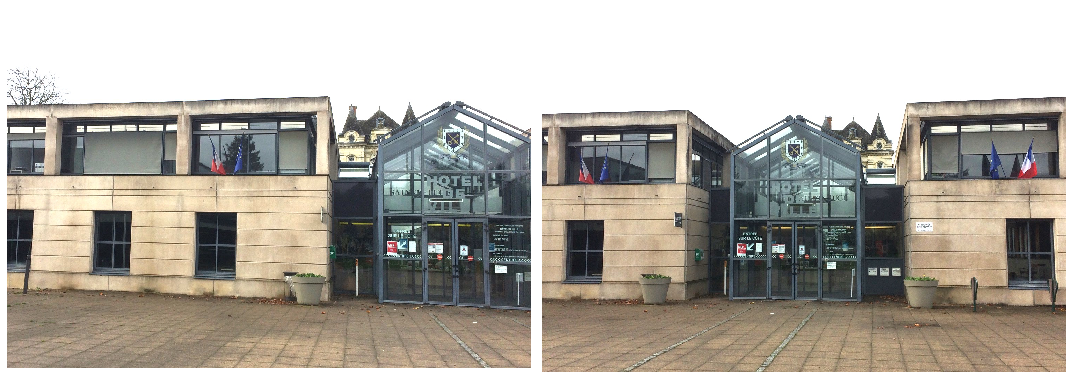

In [27]:
compare(*pano_imgs, figsize=(15, 10))

**Question 1:** Observons la paire d'images ci-dessus. 
* Quel est, à vue d'oeil, le mouvement réel 3D de la caméra ?
* Quel est, à vue d'oeil,  le mouvement 2D apparent dans l'image ?
* Quelles seront, à première vue, les difficultés pour la mise en correspondance ?


**Réponse 1:**
En 3D une rotation horizontale vers la droite
En 2D une translation vers la droite
De nouveaux éléments ontapparus et disparu entre image.

L'extraction des points d'intérêt et le calcul des descripteurs sur ces points d'intérêt se fait sur les images en niveau de gris.


### 1.2  Paire modifiée pour plus de défi

On applique aussi, optionnellement, des transformations (artificielles) sur la 2eme image, pour ajouter un peu de piquant au défi. Pour commencer, on s'en tient à une rotation de 0 et une transformation de luminance gamma=1 (pas de transformation).

Modèle de transformation= [[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


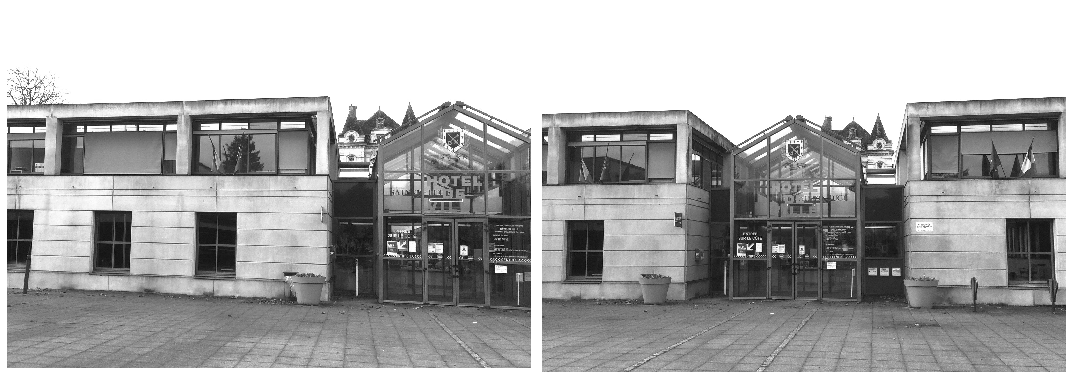

In [37]:

image0 = rgb2gray(pano_imgs[0])
image1 = rgb2gray(pano_imgs[1])


rotation_on_image = 0
scale_on_image=1
gamma_on_image=1

#rotation_on_image = math.pi/32
#scale_on_image=1.3
#gamma_on_image=1.2  # si 0<gamma<1 : plus clair, si gamma>1 : plus foncé, essayer par exemple 0.5 et 2

tform = tf.SimilarityTransform(scale=scale_on_image, rotation=rotation_on_image,
                               translation=(0, 0))

image1 = tf.warp(image1,tform)

image1=exposure.adjust_gamma(image1, gamma=gamma_on_image, gain=1)

# View the results

print("Modèle de transformation=",tform.params)
compare(image0, image1,figsize=(15, 10))

## 2. Détection des points d'intérêt

On va utiliser les "points d'intérêts" (en réalité des descripteurs locaux calculés sur des petites zones identifiées comme "très caractéristique" par un algorithme qui en extrait de l'image). De nombreux travaux de recherche et propositions ont été faites sur ce sujet dans les années 1995-2010. On utilise ici les [points-descripteurs ORB](https://uncloud.univ-nantes.fr/index.php/s/ykmSCkebZXPZQwT) (Oriented FAST and rotated BRIEF). Pour chaque point d'intérêt, un descripteur de 256 valeurs binaires (true/false) est calculé. Ce descripteur caractérise l'organisation spatiale des niveaux de gris dans une zone de 16 pixels autour du centre. Le couple choix de position-choix de descripteur local est fait pour que :

* détecter des points d'intérêt là il où il y a des coins
* plus d'invariance à des transformations géométriques et photométriques que si on prenait directement les niveaux de gris
* une représentation plus compacte (256 bits)

Les descripteurs ORB sont assez récents (2011) et choisis parce que assez précis et rapides à calculer et à exploiter (calculs de comparaison)

In [38]:
from skimage.feature import ORB

# Initialize ORB

orb = ORB(n_keypoints=800, fast_threshold=0.05,n_scales=8)

# Detect keypoints in image0
orb.detect_and_extract(image0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in image1
orb.detect_and_extract(image1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Affichons le contenu pour en avoir une petite idée

print("la structure keypoints0 dans le cas exemple de l'image 0 a pour dimension",keypoints0.shape)
print("les coordonnées des points d'intérêt sont :",keypoints0)
numero_keypoint=17  # ici on prend un des points d'intérêt juste pour voir à quoi ressemble son descripteur
print("Exemple de vecteur de description autour d'un point d'intérêt", list(map(lambda elt:1 if elt else 0, descriptors0[numero_keypoint])))


la structure keypoints0 dans le cas exemple de l'image 0 a pour dimension (800, 2)
les coordonnées des points d'intérêt sont : [[ 662.  1089. ]
 [ 663.  1116. ]
 [ 324.   615. ]
 ...
 [ 191.    61. ]
 [ 234.    63.6]
 [ 421.   977. ]]
Exemple de vecteur de description autour d'un point d'intérêt [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 

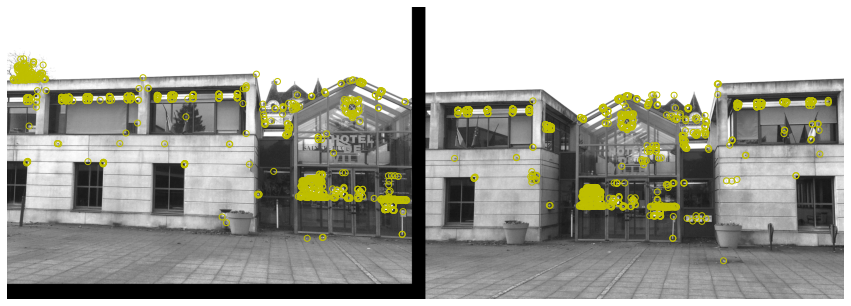

In [39]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# ci-dessous on fait le matching mais c'est juste pour profiter de la fonction d'affichage des points d'intérêt

from skimage.feature import match_descriptors
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True,max_distance=1)
plot_matches(ax,image0, image1, keypoints0, keypoints1, matches01[[]],keypoints_color='y')
ax.axis('off');

La  **répétabilité** de l'extracteur de points d'intérêt est le fait que, globalement, les mêmes points sont extraits quand l'image est prise dans des conditions de vue un peu différentes. Plus cette extraction est répétable, mieux c'est pour la réussite de l'estimation de transformation inter-images (même si ça n'est pas suffisant). Notons qu'on n'examine ici que la position des points et non la similarité entre descripteurs qui y sont calculés.

**Question 2:** Commenter la répétabilité de l'extraction des points d'intérêt en fonction de transformations géométriques et photométriques sur l'image que vous appliquerez sur l'image (partie 1.2)

**Réponse 2:** Les transformations physique ne change pas la détection des points d'intéret car la répétabilité est élevé (l'algorithme utilisé est donc efficace)

## 3. Mise en correspondance des points d'intérêts (deux à deux)

In [20]:
from skimage.feature import match_descriptors

# Cette fonction met en correspondance les descripteurs, mais n'affiche rien
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True,max_distance=1)


Deux points P1 de l'image 1 et P2 de l'image 2 sont associés si et seulement P2 est le plus proche de P1 parmi tous les points de l'image 2 et P1 est le plus proche de P2 parmi tous les points de l'image 1 (au sens de la distance de Hamming entre vecteurs binaires). 

**Question 3:** A votre avis a-t-on besoin de passer la position des points d'intérêt pour la mise en correspondance ? 

**Réponse 3:** Non, la mise en correspondance se fait par les descripteurs (au sens de hamming). Nul besoin de connaitre la position pour faire la correspondance. Si dans chaque image 2 descripteurs sont très proche, alors les 2 points seront mis en correspondance.

### Affichage de quelques correspondances trouvées (pour plus de lisibilité) 


<ipython-input-13-4b6df2aae4e7>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01[[range(25)]],keypoints_color='y')


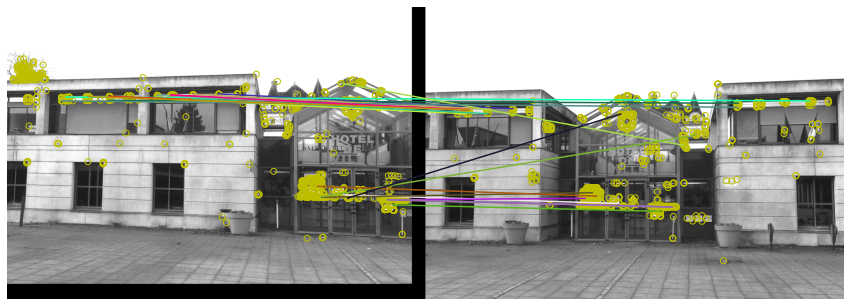

In [13]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for image0 -> image1
plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01[[range(25)]],keypoints_color='y')
ax.axis('off');

**Question 4:** 
- Evaluer à l'oeil la qualité des associations. 
- Certaines sont-elles visiblement fausses et avez-vous une idée sur la cause de l'erreur ? 
- Y a t-il des points sans correspondant dans la première et/ou la seconde image ? 
- Est-ce parce que ce ces points sont hors du champ de vision dans l'autre image ? 
- Semble t-il y avoir une majorité de points bien appariés ? 

Il peut être plus facile (ou plus difficile) de répondre à ces questions avec l'image suivante, qui montre tous les appariments.

**Réponse 4:** Bonne correspondance. Certaines sont fausses car il y'a certainement des points d'intérets dans une image en plus qui sont plus proche d'un autre point d'intéret de l'autre image. Celà sous-entend que un même point d'intéret d'une image à l'autre n'a pas forcément le même descripteur.  Certains points d'intérets sont proche de point d'intérets de l'autre image, mais ceux-ci ne sont pas proche d'eux (la correspondance n'est pas réciproque, donc ne remplis pas la condition de correspondance) C'est en partie lié au fait que certain point d'intéret sont hors champs de vision d'une image à l'autre. Mais la plupart des points sont bien appariés.

### Affichage de tous les appariements

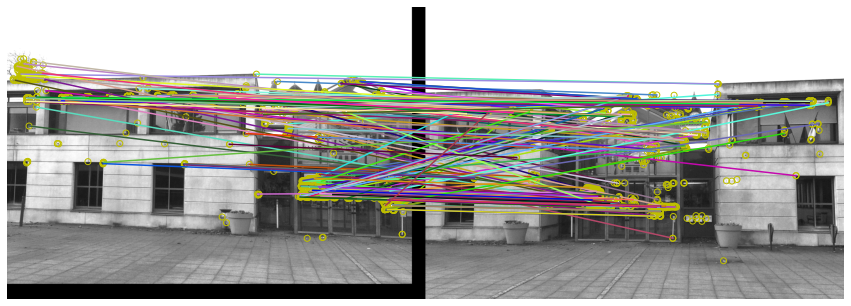

In [14]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01,keypoints_color='y')
ax.axis('off');

## 4.Estimation de la transformation

Pour tenter d'éliminer les mauvais appariements, on utilise la méthode RANdom SAMple Consensus (RANSAC), qui permet d'éliminer d'un processus d'estimation statistique les données non conformes au comportement majoritaire (estimation robuste). En (très) résumé, elle consiste à estimer des modèles à partir de divers sous-échantillons aléatoires des données et à en retenir le meilleur.


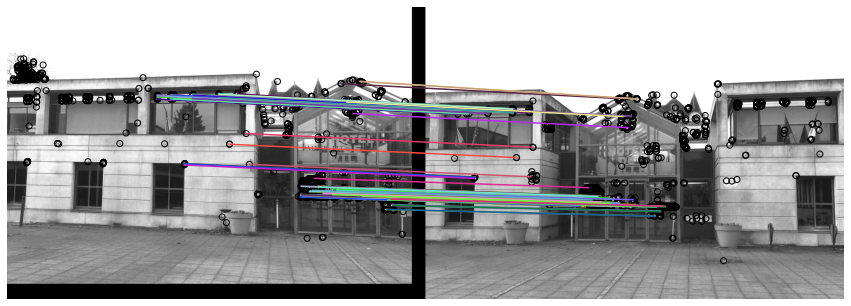

In [15]:
from skimage.transform import ProjectiveTransform,SimilarityTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]


model_robust01, inliers01 = ransac((src, dst), SimilarityTransform, min_samples=5, residual_threshold=30, max_trials=1500)

#model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform, min_samples=5, residual_threshold=30, max_trials=1500)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');


**Question 5:** 
- Etudiez expérimentalement et commentez les performances des modèles de transformations suivants, <u>en commentant l'une ou l'autre des lignes dans la case de code ci-dessous</u>.
    * [similitude](https://fr.wikipedia.org/wiki/Similitude_(géométrie)) 
    * [transformation projective](https://en.wikipedia.org/wiki/Homography). Plus générale que la similitude, elle permet de traiter le cas où une scène est prise de points de vue très distincts l'un de l'autre.
- Le processus RANSAC n'a laissé qu'une partie des appariements, qu'il identifie comme donnant une transformation géométrique cohérence. On l'affiche ci-dessous. Vous parait-elle correcte ?

**Réponse 5:** VOTRE CODE ICI

## 5 Recalage d'image et superposition

On va maintenant recaler les images et les superposer. Par recaler, on entend qu'on va transformer une des deux images par la transformation géométrique estimée entre les deux, pour que les mêmes points de la scène se retrouvent (si tout se passe bien) aux mêmes coordonnées d'image. On pourra alors superposer les deux images et mieux voir si la transformation géométrique a été bien estimée.

In [16]:
# Ici juste une partie de code pour préparer une grande image vide aux bonnes dimensions pour recevoir la superposition des deux images originales

from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners))

# The overally output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Application de la transformation

A l'aide de `skimage.transform.warp`, appliquons la transformation obtenu à l'étape précédente. Le cas de l'image du milieu est un peu particulier car c'est notre image de "référence", nous devons donc seulement la translater pour la placer au centre de l'image reconstituée.

In [17]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


# Warp image0 to image1 using 3rd order interpolation
transform01 = (model_robust01 + offset1).inverse  
image0_warped = warp(image0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

image0_mask = (image0_warped != -1)  # Mask == 1 inside image
image0_warped[~image0_mask] = 0      # Return background values to 0


# Translate pano1 into place
image1_warped = warp(image1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

image1_mask = (image1_warped != -1)  # Mask == 1 inside image
image1_warped[~image1_mask] = 0      # Return background values to 0



Regardons les deux images mises dans un repère commun :

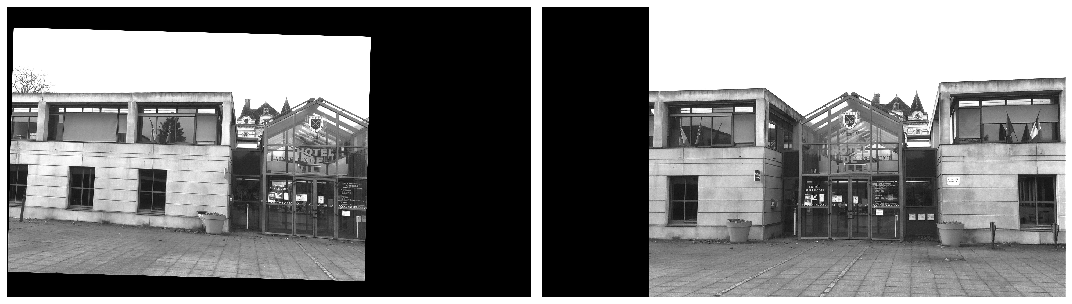

In [18]:
compare(image0_warped, image1_warped, figsize=(15, 10));

Superposons ces deux images :

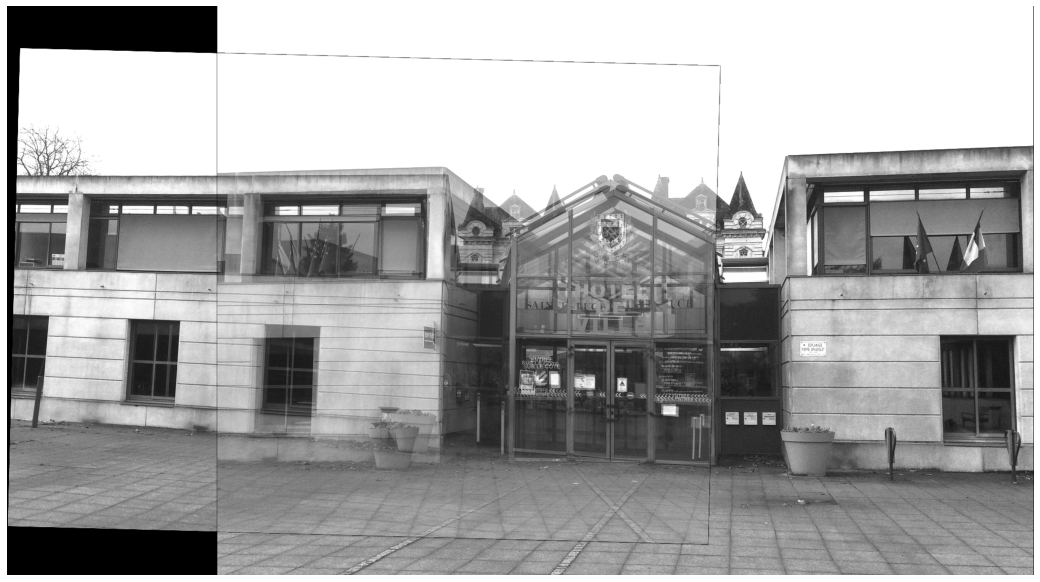

In [19]:
# Add the two images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (image0_warped + image1_warped)

# Track the overlap by adding the masks together
overlap = (image0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           image1_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

**Question 6:** Commentez la qualité de la reconstruction obtenue <u>pour les différents jeux d'images d'exemple fournis</u>. Tentez d'expliquer les cas qui ne marchent pas bien.

**Réponse 6:** VOTRE REPONSE ICI